In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
import imageio
import numpy as np
import matplotlib
from datetime import datetime
import matplotlib.animation as animation
from IPython.display import HTML

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
print(torch.__version__)
torch.cuda.is_available()

1.13.1+cu117


True

In [3]:
#data path
dataroot = "../data"

#hyper parameters
num_epochs = 5
batch_size = 64
image_size = 64
nc = 3 # number of channels
workers = 2 # number of workers for the dataloader
sample_size = 64 # fixed sample size
nz = 200 # latent size
ngf = 64 # size of feature maps in gen
ndf = 64 # size of feature maps in dis
k = 1 # steps to apply to discriminator
lr = 0.00018 # learning rate

beta1 = 0.5 # beta for adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


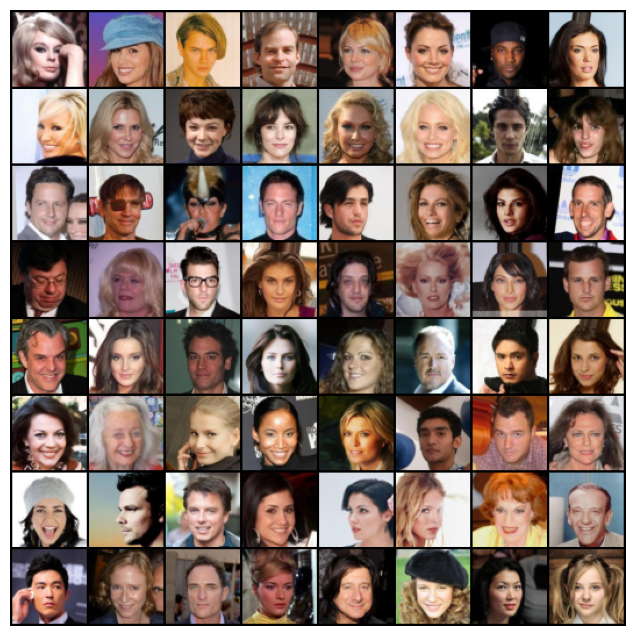

In [4]:
#load the data

#define transformation to convert images to tensors
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

to_pil_image = transforms.ToPILImage()

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

# plot some images
real_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
#generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2),
            nn.ReLU(True),
            nn.Dropout(0.3),
            
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2),
            nn.ReLU(True),
            nn.Dropout(0.3),
            
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2),
            nn.ReLU(True),
            
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )
    def forward(self, x):
        return self.main(x)
    
#discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)
    
#set up the networks
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

#print the generator and the discriminator
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

#loss function
criterion = nn.BCELoss()
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.3, inplace=False)
    (13): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [6]:
#utility functions

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

#to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

#to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

#train generator
def train_generator(optimizer, data_fake):
    #get batch size
    b_size = data_fake.size(0)
    
    #use real data to train generator
    real_label = label_real(b_size)

    #set graidents to zero
    optimizer.zero_grad()
    
    #pass the fake data to the discriminator and get output
    output = discriminator(data_fake).view(-1)
    output = output.unsqueeze(1)
    #calculate the loss
    loss = criterion(output, real_label)
    
    #backpropagate the gradients
    loss.backward()
    #update the parameters for the generator
    optimizer.step()
    
    return loss

#train discriminator
def train_discriminator(optimizer, data_real, data_fake):
    #get batch size
    b_size = data_real.size(0)
    
    #create real and fake labels
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    
    #set graidents to zero
    optimizer.zero_grad()
    
    #get output and loss from real data
    output_real = discriminator(data_real).view(-1)
    output_real = output_real.unsqueeze(1)
    loss_real = criterion(output_real, real_label)
    
    #get output and loss from fake data
    output_fake = discriminator(data_fake).view(-1)
    output_fake = output_fake.unsqueeze(1)
    loss_fake = criterion(output_fake, fake_label)
    
    #backpropagate the loss for the real and fake data
    loss_real.backward()
    loss_fake.backward()
    
    #update the parameters for the discriminator
    optimizer.step()
    
    return loss_real + loss_fake

# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [7]:
#train

img_list = []
G_losses = []
D_losses = []

#init weights
generator.apply(weights_init)
discriminator.apply(weights_init)

#start timer
start_time = datetime.now()

# create the noise vector
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#switch the networks to training mod
generator.train()
discriminator.train()

print("Starting training loop")

for epoch in range(num_epochs):
    print(f"Epoch {epoch} of {num_epochs}")
    #batch wise loss
    loss_g = 0.0
    loss_d = 0.0
    
    for bi, data in enumerate(dataloader, 0):
        #load the image data to the device        
        image, _ = data
        image = image.to(device)
        #calculate batch size
        b_size = len(image)
        
        #run the discriminator for k steps
        for step in range(k):
            #generate noise
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            data_fake = generator(noise)
            data_real = image
            #train the discriminator network
            lossd = train_discriminator(optimizerD, data_real, data_fake)
            loss_d += lossd
        
        #run the generator with new noise
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        data_fake = generator(noise)
        
        #train the generator
        lossg = train_generator(optimizerG, data_fake)
        loss_g += lossg
        #print("debug", bi)
        
        # Output training stats
        if bi % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_G: %.4f\tLoss_D: %.4f'
              % (epoch, num_epochs, bi, len(dataloader),
                 lossg, lossd))
            
        # Check how the generator is doing by saving G's output on fixed_noise
        if (bi % 500 == 0) or ((epoch == num_epochs-1) and (bi == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        G_losses.append(lossg.detach().cpu())
        D_losses.append(lossd.detach().cpu())
        
    #create the final fake image for the epoch
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    generated_img = generator(noise).cpu().detach()
    #make the images as grid
    generated_img = make_grid(generated_img)
    #save the generated torch tensor models to disk
    save_image(generated_img, f"./outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.detach().cpu())
    losses_d.append(epoch_loss_d.detach().cpu())
        
    #prints
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

    
#done training 
print("\n#### DONE TRAINING ####")
print("Total training time: %s" % (datetime.now() - start_time))


Starting training loop
Epoch 0 of 5
[0/5][0/3166]	Loss_G: 1.3512	Loss_D: 1.5962
[0/5][50/3166]	Loss_G: 7.1630	Loss_D: 0.0654
[0/5][100/3166]	Loss_G: 6.6386	Loss_D: 0.1196
[0/5][150/3166]	Loss_G: 13.9263	Loss_D: 0.0329
[0/5][200/3166]	Loss_G: 5.8283	Loss_D: 0.2467
[0/5][250/3166]	Loss_G: 7.2111	Loss_D: 0.1661
[0/5][300/3166]	Loss_G: 5.9655	Loss_D: 0.0623
[0/5][350/3166]	Loss_G: 5.2252	Loss_D: 0.4892
[0/5][400/3166]	Loss_G: 5.7928	Loss_D: 0.4756
[0/5][450/3166]	Loss_G: 6.7594	Loss_D: 0.4027
[0/5][500/3166]	Loss_G: 3.6138	Loss_D: 0.2419
[0/5][550/3166]	Loss_G: 8.0003	Loss_D: 0.4012
[0/5][600/3166]	Loss_G: 3.8109	Loss_D: 0.5668
[0/5][650/3166]	Loss_G: 4.5514	Loss_D: 0.4467
[0/5][700/3166]	Loss_G: 3.5827	Loss_D: 0.6285
[0/5][750/3166]	Loss_G: 4.9967	Loss_D: 0.1879
[0/5][800/3166]	Loss_G: 3.1339	Loss_D: 0.3815
[0/5][850/3166]	Loss_G: 4.0195	Loss_D: 0.2793
[0/5][900/3166]	Loss_G: 6.3530	Loss_D: 0.2499
[0/5][950/3166]	Loss_G: 6.2653	Loss_D: 0.3397
[0/5][1000/3166]	Loss_G: 5.2670	Loss_D: 0.1494

[2/5][2200/3166]	Loss_G: 4.7767	Loss_D: 0.4970
[2/5][2250/3166]	Loss_G: 2.6058	Loss_D: 0.4616
[2/5][2300/3166]	Loss_G: 2.4882	Loss_D: 0.2598
[2/5][2350/3166]	Loss_G: 5.0434	Loss_D: 0.5906
[2/5][2400/3166]	Loss_G: 0.8005	Loss_D: 0.9208
[2/5][2450/3166]	Loss_G: 1.1622	Loss_D: 0.4033
[2/5][2500/3166]	Loss_G: 3.6595	Loss_D: 0.3058
[2/5][2550/3166]	Loss_G: 1.8401	Loss_D: 0.3927
[2/5][2600/3166]	Loss_G: 2.8163	Loss_D: 0.6410
[2/5][2650/3166]	Loss_G: 2.0869	Loss_D: 0.4510
[2/5][2700/3166]	Loss_G: 3.0597	Loss_D: 0.4762
[2/5][2750/3166]	Loss_G: 3.3101	Loss_D: 0.3934
[2/5][2800/3166]	Loss_G: 3.8149	Loss_D: 0.2813
[2/5][2850/3166]	Loss_G: 3.4648	Loss_D: 0.3811
[2/5][2900/3166]	Loss_G: 2.1745	Loss_D: 0.8956
[2/5][2950/3166]	Loss_G: 3.2776	Loss_D: 0.4419
[2/5][3000/3166]	Loss_G: 3.9065	Loss_D: 0.3896
[2/5][3050/3166]	Loss_G: 3.1037	Loss_D: 0.3208
[2/5][3100/3166]	Loss_G: 1.3410	Loss_D: 0.5602
[2/5][3150/3166]	Loss_G: 2.8373	Loss_D: 0.2759
Generator loss: 3.00861001, Discriminator loss: 0.58849257
E

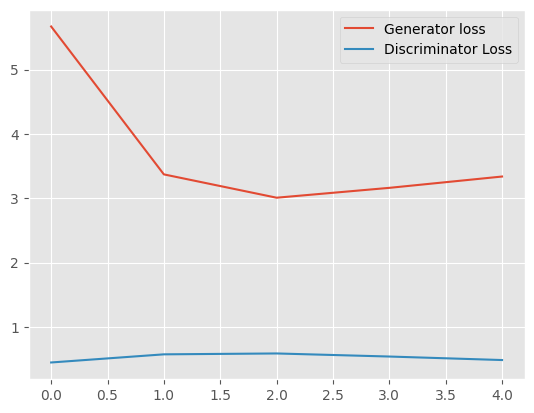

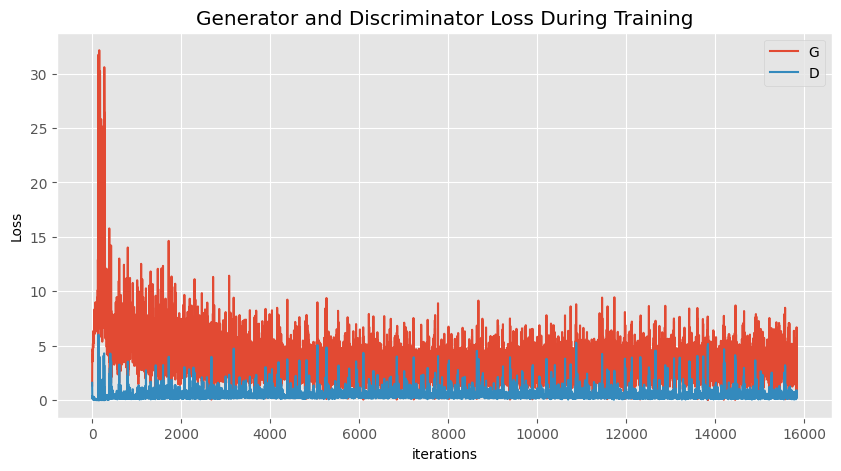

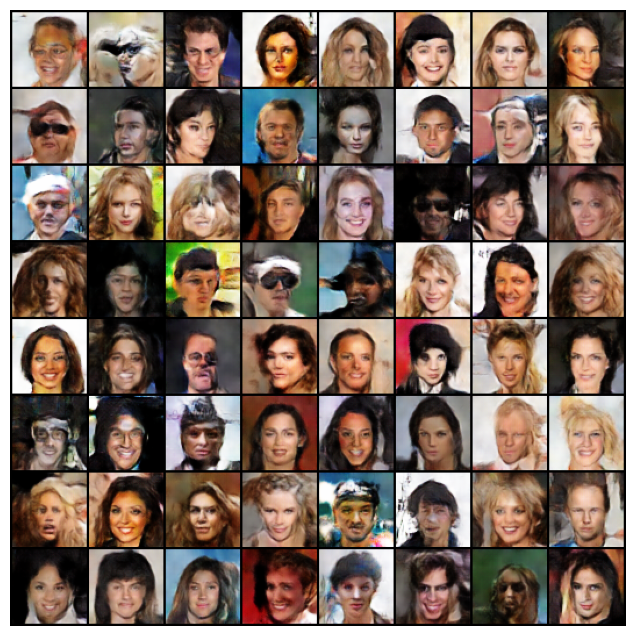

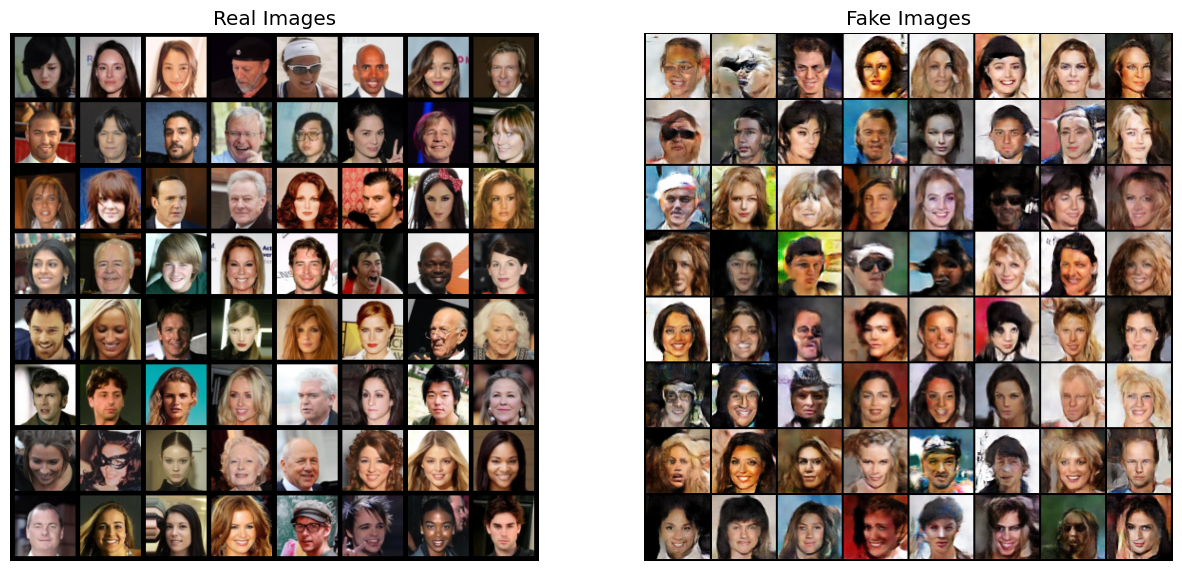

In [8]:
#save generator
torch.save(generator.state_dict(), './outputs/generator.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in img_list]
imageio.mimsave('./outputs/generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/epoch_loss.png')

# plot loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
#plt.show()
plt.savefig('./outputs/loss.png')

# aniamte images
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
#plt.show()
plt.savefig('./outputs/real_vs_fake.png')